# Evolution problems

## The Heat Equation on an infinite strip

In this example, we consider the one-dimensional heat equation on a strip of length $2L$, that is, on the spatial domain $$ x \in [-L, L] $$ with $L$ chosen large enough to approximate an infinite domain. The governing equation is

$$
u_t = u_{xx},
$$

with an initial condition given by a Gaussian pulse,

$$
u(x, 0) = \exp(-x^2),
$$

and homogeneous Dirichlet boundary conditions

$$
u(-L,t) = u(L,t) = 0 \quad \text{for } t > 0.
$$

Physically, the heat equation models the diffusion of heat (or other diffusive substances) in a medium. In our case, the Gaussian pulse represents an initial localized deposit of heat that then spreads out (or "smears") over time. The analytical solution for an infinite domain with this initial condition is known and given by

$$
u(x,t) = \frac{1}{\sqrt{1 + 4t}} \exp\left(-\frac{x^2}{1 + 4t}\right).
$$

Even though our domain is finite, choosing a sufficiently large $L$ ensures that the boundaries do not affect the solution significantly over the time interval of interest.

## Numerical Strategies

To solve this heat equation numerically, we implement and compare two different approaches:

### 1. Method-of-Lines (MoL)

The method-of-lines strategy involves discretizing the spatial derivatives while leaving the time derivative continuous. This leads to a system of ordinary differential equations (ODEs) in time. In our implementation:

- **Spatial Discretization:**  
  The spatial derivative $u_{xx}$ is approximated using central finite differences:
  
  $$
  u_{xx}(x_i,t) \approx \frac{u(x_{i+1},t) - 2\,u(x_i,t) + u(x_{i-1},t)}{(\Delta x)^2}.
  $$
  
  Homogeneous Dirichlet boundary conditions are imposed at $x=-L$ and $x=L$. The resulting problem is a system of ODEs for each degree of freedom $u_i$, given by:

  $$\frac{du_i}{dt} = \frac{1}{\Delta x^2} (u_{i+1} - 2 u_i + u_{i-1}),$$

  where care must be taken when dealing with the boundary conditions.

- **Time Integration:**  
  The resulting ODE system is integrated in time using an ODE solver (here `solve_ivp` from SciPy), provided the initial condition above. This approach is flexible as it leverages adaptive time stepping and allows the use of robust ODE solvers.

### 2. Crank–Nicolson Scheme

The Crank–Nicolson method is a fully discrete, implicit finite difference scheme that discretizes both time and space. It is based on the trapezoidal rule in time and central differences in space. The discretization reads as follows for interior grid points:

$$
\frac{u_i^{n+1} - u_i^{n}}{\Delta t} = \frac{1}{2}\left[\frac{u_{i+1}^{n} - 2\,u_i^{n} + u_{i-1}^{n}}{(\Delta x)^2} + \frac{u_{i+1}^{n+1} - 2\,u_i^{n+1} + u_{i-1}^{n+1}}{(\Delta x)^2}\right].
$$

Some key features of this method are:

- **Implicit Time Stepping:**  
  At each time step, a tridiagonal system of linear equations must be solved, which can be efficiently handled by banded matrix solvers.

- **Second-Order Accuracy:**  
  The scheme is second-order accurate in both time and space, and it is unconditionally stable for linear problems like the heat equation.

- **Boundary Conditions:**  
  The Dirichlet boundaries are directly enforced during the solution of the linear system at every time step.

## Comparison

Both the MoL and Crank–Nicolson approaches are used to simulate the evolution of the Gaussian pulse over time. The analytic solution 

$$
u(x,t) = \frac{1}{\sqrt{1+4t}} \exp\left(-\frac{x^2}{1+4t}\right)
$$

serves as a benchmark to assess the accuracy of the numerical methods. In the notebook, the numerical solutions are compared against the analytic solution at various time levels. This comparison allows us to study the accuracy, stability, and computational efficiency of both the method-of-lines and the Crank–Nicolson scheme.

By exploring these two strategies, one gains insights into the trade-offs between the flexibility of using ODE solvers (MoL) and the robustness of classical fully discrete schemes (Crank–Nicolson) for solving parabolic partial differential equations.


#### Discretization of the RHS of the equation

In [1]:
import numpy as np

# --------------------------
# Spatial Discretization Parameters
# --------------------------
L = 10.0                # Domain: x in [-L, L]
Nx = 401                # Number of spatial grid points
x = np.linspace(-L, L, Nx)
dx = x[1] - x[0]        # Spatial step size

# --------------------------
# Spatial Operator Function: Discrete Laplacian
# --------------------------
def laplacian(u):
    """
    Compute the discrete second derivative (Laplacian) using central differences.
    Homogeneous Dirichlet BCs are assumed (u[0] = u[-1] = 0).
    """
    d2udx2 = np.zeros_like(u)
    # Compute central difference for interior points:
    d2udx2[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2]) / dx**2
    # Boundary values remain zero (Dirichlet condition)
    return d2udx2


#### Method-of-Lines implementation:

In [2]:
from scipy.integrate import solve_ivp

# --------------------------
# MoL Problem Parameters
# --------------------------
t_final = 2.0                        # Final simulation time
u0 = np.exp(-x**2)                   # Initial condition: Gaussian pulse

# --------------------------
# Define the RHS for the ODE system using the shared spatial operator
# --------------------------
def heat_rhs(t, u):
    # The heat equation: u_t = u_xx
    dudt = laplacian(u)
    # Enforce homogeneous Dirichlet conditions implicitly by not updating boundaries:
    dudt[0] = 0
    dudt[-1] = 0
    return dudt

# Solve the ODE system:
sol_MoL = solve_ivp(heat_rhs, [0, t_final], u0, method='RK45', atol=1e-12)


#### Crank-Nicolson implementation:

In [3]:
from scipy.linalg import solve_banded

# --------------------------
# CN Problem Parameters
# --------------------------
dt = t_final / 1000      # Time step size (adjust for convergence)
Nt = int(t_final / dt)   # Total number of time steps

# Initial condition:
u0_CN = np.exp(-x**2)
# Number of interior grid points (excluding boundaries)
N_interior = Nx - 2

# --------------------------
# Assemble the Crank–Nicolson Matrices
# --------------------------
r = dt / (2 * dx**2)   # CN parameter

# For the left-hand side (matrix A):
lower = -r * np.ones(N_interior - 1)
main  = (1 + 2*r) * np.ones(N_interior)
upper = -r * np.ones(N_interior - 1)

# Create the banded matrix A in the format needed by solve_banded (upper, main, lower)
A_banded = np.zeros((3, N_interior))
A_banded[0, 1:] = upper   # Upper diagonal
A_banded[1, :]  = main    # Main diagonal
A_banded[2, :-1] = lower  # Lower diagonal

# For the right-hand side (matrix B):
lower_B = r * np.ones(N_interior - 1)
main_B  = (1 - 2*r) * np.ones(N_interior)
upper_B = r * np.ones(N_interior - 1)

# Prepare storage for the CN solution (including boundaries)
sol_CN = np.zeros((Nt+1, Nx))
sol_CN[0, :] = u0_CN.copy()  # Set initial condition

# Set initial condition for the interior points
u_CN = u0_CN[1:-1].copy()

# --------------------------
# Crank–Nicolson Time-Stepping Loop
# --------------------------
for n in range(Nt):
    # Compute the right-hand side b = B * u^n for interior points
    b = np.zeros(N_interior)
    # First interior node:
    b[0] = main_B[0] * u_CN[0] + (upper_B[0] if N_interior > 1 else 0) * (u_CN[1] if N_interior > 1 else 0)
    # Interior nodes:
    for i in range(1, N_interior-1):
        b[i] = lower_B[i-1] * u_CN[i-1] + main_B[i] * u_CN[i] + upper_B[i] * u_CN[i+1]
    # Last interior node:
    b[-1] = lower_B[-1] * u_CN[-2] + main_B[-1] * u_CN[-1]
    
    # Solve for u^{n+1} (interior nodes) using the banded solver:
    u_CN = solve_banded((1, 1), A_banded, b)
    
    # Reconstruct the full solution (including boundary values set to 0):
    u_full = np.zeros(Nx)
    u_full[0] = 0           # Dirichlet BC at x = -L
    u_full[1:-1] = u_CN
    u_full[-1] = 0          # Dirichlet BC at x = L
    sol_CN[n+1, :] = u_full


Now we plot both strategies at selected instants of time:

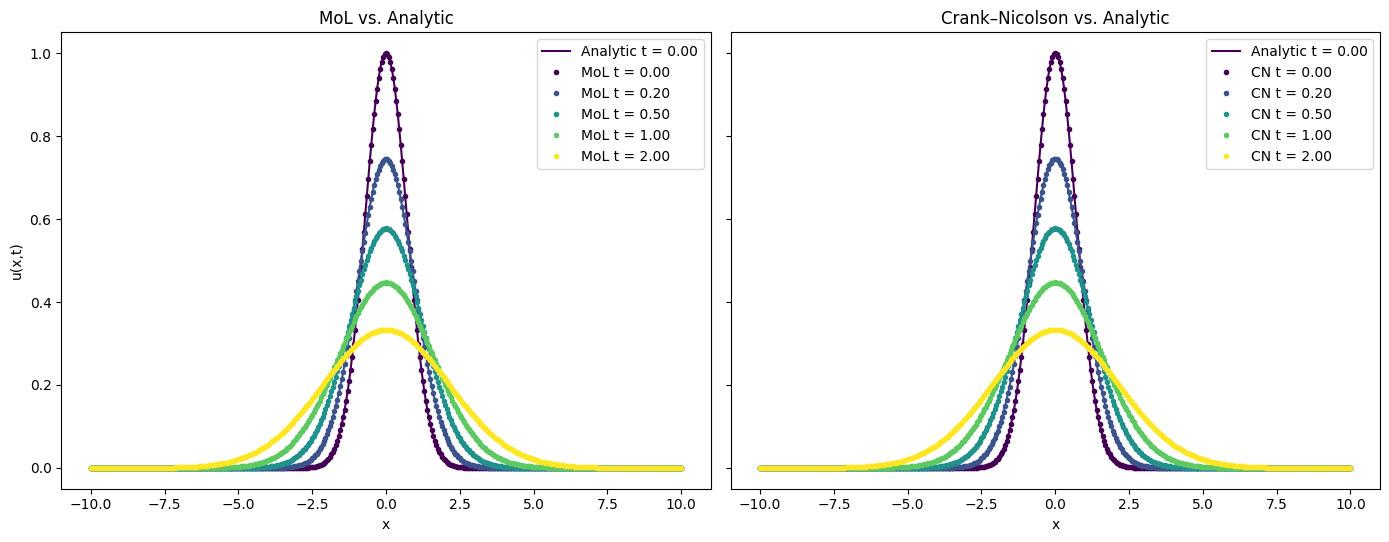

Max error at t = 2.0 (MoL): 2.434e-05
Max error at t = 2.0 (Crank–Nicolson): 2.055e-05


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------
# Define the Analytic Solution
# --------------------------
def analytic_solution(x, t):
    # Analytic solution for the infinite domain:
    return 1.0 / np.sqrt(1 + 4*t) * np.exp(-x**2 / (1 + 4*t))

# --------------------------
# Selected Time Instants for Plotting
# --------------------------
times_to_plot = [0, t_final/10, t_final/4, t_final/2, t_final]

# Create a colormap instance from "viridis"
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(times_to_plot))]

# Create 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plotting in the left subplot: MoL vs. analytic solution
for idx, t_val in enumerate(times_to_plot):
    color = colors[idx]
    # Analytic solution at t_val
    u_analytic = analytic_solution(x, t_val)
    
    # MoL solution: find the index in sol_MoL.t that is closest to t_val
    idx_MoL = np.argmin(np.abs(sol_MoL.t - t_val))
    u_MoL = sol_MoL.y[:, idx_MoL]
    
    # Plot analytic (dashed) and MoL (solid) solutions in the same color
    axes[0].plot(x, u_analytic, '-', color=color, label=f'Analytic t = {t_val:.2f}' if idx==0 else "")
    axes[0].plot(x, u_MoL, '.', color=color, label=f'MoL t = {t_val:.2f}')
    
axes[0].set_xlabel('x')
axes[0].set_ylabel('u(x,t)')
axes[0].set_title('MoL vs. Analytic')
# axes[0].grid(True)
axes[0].legend(loc="best")

# Plotting in the right subplot: CN vs. analytic solution
for idx, t_val in enumerate(times_to_plot):
    color = colors[idx]
    # Analytic solution at t_val
    u_analytic = analytic_solution(x, t_val)
    
    # CN solution: choose corresponding index (dt is the time step)
    idx_CN = int(round(t_val / dt))
    idx_CN = min(idx_CN, sol_CN.shape[0]-1)
    u_CN_plot = sol_CN[idx_CN, :]
    
    # Plot analytic (dashed) and CN (dotted) solutions in the same color
    axes[1].plot(x, u_analytic, '-', color=color, label=f'Analytic t = {t_val:.2f}' if idx==0 else "")
    axes[1].plot(x, u_CN_plot, '.', color=color, label=f'CN t = {t_val:.2f}')
    
axes[1].set_xlabel('x')
axes[1].set_title('Crank–Nicolson vs. Analytic')
# axes[1].grid(True)
axes[1].legend(loc="best")

# plt.suptitle('Heat Equation Solutions: Comparison by MoL and CN')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --------------------------
# Error Analysis at Final Time
# --------------------------
u_exact_final = analytic_solution(x, t_final)
error_MoL = np.linalg.norm(sol_MoL.y[:, -1] - u_exact_final, ord=np.inf)
error_CN = np.linalg.norm(sol_CN[-1, :] - u_exact_final, ord=np.inf)
print(f'Max error at t = {t_final} (MoL): {error_MoL:.3e}')
print(f'Max error at t = {t_final} (Crank–Nicolson): {error_CN:.3e}')


## Transient Poiseuille flow

Consider the following parabolic evolution problem that models the settling of a Poiseuille flow from rest. The governing equation is

$$
\rho u_t = P_l + \mu u_{yy}, \quad 0 < y < h,
$$

with the following boundary and initial conditions:

- **Neumann condition at the symmetry plane (y = 0):** $ u'(0) = 0, $
- **Dirichlet condition at the channel wall (y = h):** $ u(h) = 0, $
- **Initial condition:**  $ u(y, 0) = 0. $

The steady state solution is obtained by setting $$ u_t = 0 $$. By integrating twice and applying the boundary conditions, the analytical steady state solution is

$$
u_{\mathrm{ss}}(y) = \frac{P_l}{2\mu}(h^2 - y^2).
$$

### Numerical Strategy

In this exercise, we will take $P_l = \mu = \rho = 2h = 1$. we solve the transient Poiseuille problem using two numerical methods:

1. **Method-of-Lines (MoL):**  
   The spatial domain is discretized using finite differences to approximate the second derivative, $ u_{yy}, $ while time remains continuous. This produces a system of ordinary differential equations (ODEs) that is integrated with a time-stepping ODE solver.

2. **Crank–Nicolson (CN) Scheme:**  
   This is a fully discrete, implicit method that employs a trapezoidal rule in time combined with a second-order central difference approximation in space. The result is a tridiagonal system of equations solved at each time step.

Both methods will be implemented using a shared spatial discretization so that their results can be directly compared with the analytical steady state solution.


#### Discretization of the second-derivative operator

In [5]:
import numpy as np

# --------------------------
# Domain and Discretization Parameters
# --------------------------
h = 0.5                 # Channel half-width; y in [0, h]
N = 51                  # Number of grid points
y = np.linspace(0, h, N)
dy = y[1] - y[0]

# --------------------------
# Spatial Operator: Discrete Laplacian for Poiseuille Problem
# --------------------------
def laplacian(u):
    """
    Compute u_{yy} on [0,h] using central differences,
    with:
      - Neumann BC at y=0: u'(0)=0 implemented via a ghost point, i.e.,
        u_{yy}(0) ≈ (u[1]-2*u[0]+u[1])/(dy^2) = 2*(u[1]-u[0])/(dy^2)
      - Dirichlet BC at y=h: u(h)=0.
    """
    d2udy2 = np.zeros_like(u)
    # At y = 0: use ghost point (u[-1] is replaced by u[1])
    d2udy2[0] = 2 * (u[1] - u[0]) / (dy**2)
    # For interior points:
    for i in range(1, N-1):
        d2udy2[i] = (u[i+1] - 2*u[i] + u[i-1]) / (dy**2)
    # At y = h (last node), u is prescribed to be zero so the value is not used.
    d2udy2[-1] = 0
    return d2udy2


#### Solution with MoL

In [6]:
from scipy.integrate import solve_ivp

# --------------------------
# MoL Problem Parameters
# --------------------------
tf = 1.0                         # Final time
t_eval = np.linspace(0, tf, 101)    # Time evaluation points
u0 = np.zeros(N)                  # Initial condition: u(y,0) = 0

# --------------------------
# Define the RHS for the ODE System
# --------------------------
def poiseuille_rhs(t, u):
    # The Poiseuille evolution: u_t = 1 + u_{yy}
    dudt = 1.0 + laplacian(u)
    # Enforce the Dirichlet BC at y = h: u(h)=0 (the last node is fixed)
    dudt[-1] = 0
    return dudt

# Solve the ODE system via an ODE solver (e.g., RK45)
sol_MoL = solve_ivp(poiseuille_rhs, [0, tf], u0, t_eval=t_eval, method='RK45')


#### Solution with CN

In [7]:
from scipy.linalg import solve_banded

# --------------------------
# CN Problem Parameters
# --------------------------
dt = tf / 1000             # Time step size (adjustable)
Nt = int(tf/dt)            # Total number of time steps
N_interior = N - 1         # Unknown nodes: y[0] to y[N-2]; u(y=h) is prescribed (0)

# --------------------------
# Assemble CN Matrices
# --------------------------
# For the PDE: u_t = 1 + u_{yy}, the CN discretization reads (for interior nodes):
#   u_i^{n+1} - (dt/2)*L(u^{n+1}) = u_i^n + dt + (dt/2)*L(u^n),
# where L(u) denotes the discrete Laplacian.
# Define r = dt/(2*dy^2)
r = dt / (2 * dy**2)

# Initialize matrices A and B for interior nodes.
A = np.zeros((N_interior, N_interior))
B = np.zeros((N_interior, N_interior))

# --- Row 0: at y = 0, using Neumann BC (u'(0)=0) ---
A[0, 0] = 1 + dt/dy**2         # from  u_0^{n+1} - (dt/2)*(2*(u_1^{n+1} - u_0^{n+1})/dy^2)
if N_interior > 1:
    A[0, 1] = - dt/dy**2
B[0, 0] = 1 - dt/dy**2
if N_interior > 1:
    B[0, 1] = dt/dy**2

# --- Interior nodes: for i = 1, ..., N_interior-2 ---
for i in range(1, N_interior-1):
    A[i, i-1] = -r
    A[i, i]   = 1 + 2*r
    A[i, i+1] = -r

    B[i, i-1] = r
    B[i, i]   = 1 - 2*r
    B[i, i+1] = r

# --- Last row: at i = N_interior-1, corresponding to y = y[N-2] (with u(y=h)=0) ---
if N_interior > 1:
    A[-1, -2] = -r
    A[-1, -1] = 1 + 2*r

    B[-1, -2] = r
    B[-1, -1] = 1 - 2*r
else:
    # If only one unknown exists, use the Neumann-style coefficients.
    A[-1, -1] = 1 + dt/dy**2
    B[-1, -1] = 1 - dt/dy**2

# Convert matrix A to banded form for the solver
A_banded = np.zeros((3, N_interior))
for i in range(N_interior-1):
    A_banded[0, i+1] = A[i, i+1]   # upper diagonal
A_banded[1, :] = np.diag(A)        # main diagonal
for i in range(1, N_interior):
    A_banded[2, i-1] = A[i, i-1]     # lower diagonal

# --------------------------
# Time-Stepping Loop for CN
# --------------------------
# Preallocate full-solution array (including boundary at y=h)
sol_CN = np.zeros((Nt+1, N))
# Set initial condition (u(y,0)=0 everywhere)
u0_CN = np.zeros(N)
sol_CN[0, :] = u0_CN.copy()
# Initial interior solution vector
u_CN = u0_CN[:N_interior].copy()

for n in range(Nt):
    # Compute right-hand side: b = B*u^n + dt*1 (forcing term) for interior nodes.
    b = np.zeros(N_interior)
    if N_interior > 1:
        b[0] = B[0,0]*u_CN[0] + B[0,1]*u_CN[1]
    else:
        b[0] = B[0,0]*u_CN[0]
    for i in range(1, N_interior-1):
        b[i] = B[i, i-1]*u_CN[i-1] + B[i, i]*u_CN[i] + B[i, i+1]*u_CN[i+1]
    if N_interior > 1:
        b[-1] = B[-1, -2]*u_CN[-2] + B[-1, -1]*u_CN[-1]
    # Add forcing term (dt*1) uniformly:
    b += dt * np.ones(N_interior)
    
    # Solve the linear system for interior nodes:
    u_CN = solve_banded((1,1), A_banded, b)
    
    # Reconstruct full solution: u(y=h)=0 by design.
    u_full = np.zeros(N)
    u_full[:N_interior] = u_CN
    u_full[-1] = 0
    sol_CN[n+1, :] = u_full.copy()


And now we plot...

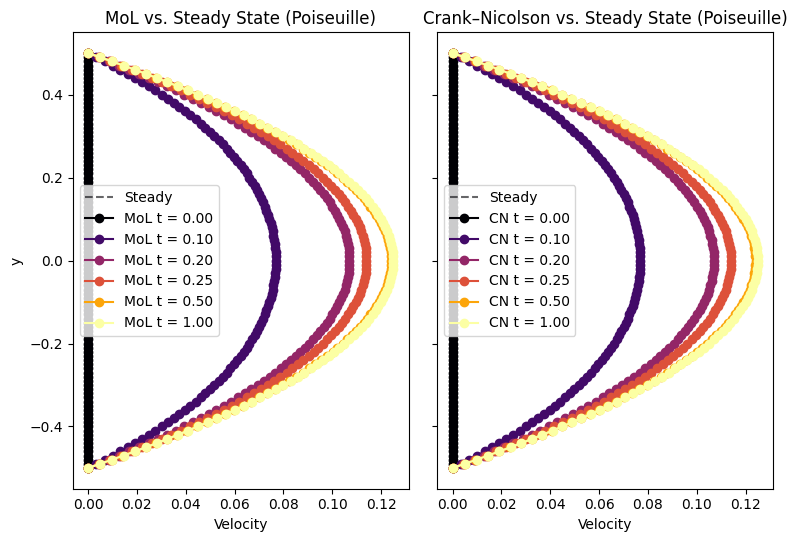

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------
# Define the Steady State Solution
# --------------------------
def steady_solution(y):
    # Steady state: u_ss(y)= 1/2*h^2 - 1/2*y^2 on [0,h]
    return 0.5 * h**2 - 0.5 * y**2

# --------------------------
# Selected Time Instants for Plotting
# --------------------------
times_to_plot = [0, tf/10, tf/5, tf/4, tf/2, tf]
cmap = plt.get_cmap('inferno')
colors = [cmap(i) for i in np.linspace(0, 1, len(times_to_plot))]

# Create a full y-axis by mirroring the half-domain [0, h] to [-h, h]
# Exclude the duplicate 0 from the negative side.
y_full = np.concatenate((-y[1:][::-1], y))

# --------------------------
# Create 1x2 Subplots
# --------------------------
fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=True)

# --- Left Subplot: MoL vs. Steady State ---
for idx, t_val in enumerate(times_to_plot):
    color = colors[idx]
    
    # Find the MoL solution at time t_val:
    idx_MoL = np.argmin(np.abs(sol_MoL.t - t_val))
    u_MoL_half = sol_MoL.y[:, idx_MoL]  # defined for y in [0, h]
    
    # Mirror the half-domain solution to obtain the full profile:
    # Exclude the duplicate at y=0.
    u_MoL_full = np.concatenate((u_MoL_half[1:][::-1], u_MoL_half))
    
    # Steady-state computed on [0, h] and mirrored
    u_ss_half = steady_solution(y)
    u_ss_full = np.concatenate((u_ss_half[1:][::-1], u_ss_half))
    
    # Plot the analytic steady profile as a dashed line
    axes[0].plot(u_ss_full, y_full, '--', color=color, alpha=0.6, label='Steady' if idx==0 else "")
    # Plot the MoL solution as a solid line with markers
    axes[0].plot(u_MoL_full, y_full, 'o-', color=color, label=f'MoL t = {t_val:.2f}')
    
axes[0].set_xlabel('Velocity')
axes[0].set_ylabel('y')
axes[0].set_title('MoL vs. Steady State (Poiseuille)')
axes[0].legend(loc='best')
# axes[0].grid(True)

# --- Right Subplot: Crank–Nicolson vs. Steady State ---
for idx, t_val in enumerate(times_to_plot):
    color = colors[idx]
    
    # For CN, choose the corresponding index (rounding t_val/dt)
    idx_CN = int(round(t_val / dt))
    idx_CN = min(idx_CN, sol_CN.shape[0]-1)
    u_CN_half = sol_CN[idx_CN, :]  # defined for y in [0, h]
    
    # Mirror the CN half-domain solution:
    u_CN_full = np.concatenate((u_CN_half[1:][::-1], u_CN_half))
    
    # Steady state is the same as above
    u_ss_half = steady_solution(y)
    u_ss_full = np.concatenate((u_ss_half[1:][::-1], u_ss_half))
    
    axes[1].plot(u_ss_full, y_full, '--', color=color, alpha=0.6, label='Steady' if idx==0 else "")
    axes[1].plot(u_CN_full, y_full, 'o-', color=color, label=f'CN t = {t_val:.2f}')
    
axes[1].set_xlabel('Velocity')
axes[1].set_title('Crank–Nicolson vs. Steady State (Poiseuille)')
axes[1].legend(loc='best')
# axes[1].grid(True)

# plt.suptitle('Settling Poiseuille Flow: Velocity Profiles vs. y (Mirrored)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [9]:
# --------------------------
# Error Analysis at Final Time
# --------------------------
u_steady_half = steady_solution(y)
u_steady_full = np.concatenate((u_steady_half[1:][::-1], u_steady_half))
error_MoL = np.linalg.norm(np.concatenate((sol_MoL.y[1:, -1][::-1], sol_MoL.y[:, -1])) - u_steady_full, ord=np.inf)
error_CN   = np.linalg.norm(np.concatenate((sol_CN[-1, 1:][::-1], sol_CN[-1, :])) - u_steady_full, ord=np.inf)
print(f'Max error at t = {tf} (MoL): {error_MoL:.3e}')
print(f'Max error at t = {tf} (Crank–Nicolson): {error_CN:.3e}')


Max error at t = 1.0 (MoL): 2.512e-05
Max error at t = 1.0 (Crank–Nicolson): 6.677e-06


## The Thin-Film Equation

In this problem we study the evolution of a thin liquid film on a substrate. The dynamics of the film are governed by a fourth-order nonlinear parabolic equation (which esentially is a Reynolds equation for the thickness $h(x,t)$ of the film), which in nondimensional form reads 

$$
h_t = \partial_x \Bigl( M\, \partial_x p \Bigr), \quad \text{for } t > 0 \text{ and } 0 < x < x_d,
$$

where the mobility is given by $M = \frac{h^3}{3}$, and the pressure is defined as (Laplace plus molecular)

$$
p = -h_{xx} + \phi(h).
$$

The molecular potential is modeled by

$$
\phi(h) = A \left( \frac{1}{h^3} - \frac{h_s^6}{h^9} \right),
$$

where:
- $A$ is the dimensionless Hamaker constant,
- $h_s$ is the dimensionless precursor-film thickness.

### Boundary and Initial Conditions

We consider only the half-domain $0 < x < x_d$, and impose symmetry at the origin ($x = 0$) by enforcing

$$
h_x(0) = 0 \quad \text{and} \quad p_x(0) = 0,
$$

and similar zero-flux conditions at the downstream boundary $x = x_d$. The initial condition is given by a smooth hyperbolic tangent profile that transitions from the precursor film thickness $h_s$ to 1 over a distance roughly of order $\pi/k$, where

$$
k = \sqrt{\frac{3A}{2}}.
$$

Thus, the initial condition takes the form

$$
h(x, 0) = h_s + (1-h_s)\, \frac{1}{2}\left(1+\tanh\left(\frac{x-\pi/k}{\text{width}}\right)\right),
$$

with a specified width to control the smoothness of the transition.

### Numerical Strategy

The evolution of $h(x,t)$ is simulated using a **Method-of-Lines (MoL)** approach:
- **Spatial Discretization:**  
  The spatial derivatives are approximated with second-order finite difference methods. In particular, the conservative form of the spatial operator is used to discretize 
  $$
  \partial_x\Bigl(M\, \partial_x p\Bigr),
  $$
  directly, ensuring that the conservation properties of the original PDE are preserved. Special care is taken at the boundaries to enforce the Neumann-type (zero-gradient) conditions using one-sided differences.
  
- **Time Integration:**  
  The semi-discrete system (obtained after spatial discretization) is then integrated in time using a built-in time integrator (RK23). This explicit scheme is well suited for the moderately stiff nature of the thin-film equation when a proper spatial mesh is chosen.

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ==========================
# Parameters and Domain Setup
# ==========================

# Model parameters
A   = 0.1            # Dimensionless Hamaker constant
h_s = 0.2            # Dimensionless precursor-film thickness
k   = np.sqrt(3*A/2.0)  # Wavenumber: k = sqrt(3A/2)

# Domain
N = 12               # Integer multiple for domain length
x_d = N * np.pi/k    # Downstream extent; here we study x in [0, x_d]

# Spatial grid for x in [0, x_d]
Nx = 501
x = np.linspace(0, x_d, Nx)
dx = x[1] - x[0]

# Final time for simulation
tf = 300.0

# ==========================
# Initial Condition
# ==========================
# Use a smooth hyperbolic tangent profile that transitions from h_s to 1 near x ~ pi/k.
# Choose a width parameter (here, e.g., 0.1*(pi/k)) to control the smoothness of the transition.
width = 0.1 * (np.pi/k)
h0 = h_s + (1 - h_s) * 0.5 * (1 + np.tanh((x - np.pi/k) / width))
# For x sufficiently less than pi/k, h ~ h_s; for x larger, h ~ 1.

# ==========================
# Finite Difference Operators with Neumann BC at both boundaries
# ==========================

def second_derivative(u, dx):
    """
    Compute the second derivative using second-order central differences.
    Neumann BC: u_x = 0 is enforced at both boundaries using ghost-point mirroring.
    """
    d2u = np.zeros_like(u)
    # Left boundary: use ghost point u[-1] = u[1]
    d2u[0] = (u[1] - 2*u[0] + u[1])/(dx**2)  # = 2*(u[1]-u[0])/dx**2
    # Right boundary: use ghost point u[N] = u[N-2]
    d2u[-1] = (u[-2] - 2*u[-1] + u[-2])/(dx**2)  # = 2*(u[-2]-u[-1])/dx**2
    # Interior
    d2u[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2])/(dx**2)
    return d2u

def first_derivative(u, dx):
    """
    Compute the first derivative using second-order central differences.
    At the boundaries, a one-sided second-order difference is used.
    """
    du = np.zeros_like(u)
    # Left boundary: second-order forward difference
    du[0] = (-3*u[0] + 4*u[1] - u[2])/(2*dx)
    # Right boundary: second-order backward difference
    du[-1] = (3*u[-1] - 4*u[-2] + u[-3])/(2*dx)
    # Interior: central differences
    du[1:-1] = (u[2:] - u[:-2])/(2*dx)
    return du

def conservative_derivative(flux, dx):
    """
    Compute the derivative of a flux function using a second-order central difference
    that is formulated in conservative form.
    At the boundaries, one-sided differences are used.
    """
    dflux = np.zeros_like(flux)
    # Left boundary: forward difference
    dflux[0] = (flux[1] - flux[0]) / dx
    # Right boundary: backward difference
    dflux[-1] = (flux[-1] - flux[-2]) / dx
    # Interior: central difference
    dflux[1:-1] = (flux[2:] - flux[:-2])/(2*dx)
    return dflux

# ==========================
# Define the RHS of the Thin-Film Equation
# ==========================
def thinfilm_rhs(t, h):
    """
    Compute h_t = d/dx( M * d/dx(p) ) for the thin-film equation,
    where:
      M = h^3/3,
      p = -h_xx + phi(h),
      phi(h) = A*(1/h^3 - h_s^6/h^9).
    
    The spatial derivatives are computed using second-order finite differences in conservative form.
    Boundary conditions: 
      h_x = 0 and p_x = 0 at x = 0 and x = x_d.
    """
    # Compute h_xx (for the curvature term)
    h_xx = second_derivative(h, dx)
    
    # Compute molecular potential phi
    phi = A * (1.0/h**3 - h_s**6/h**9)
    
    # Pressure p = -h_xx + phi
    p = -h_xx + phi
    
    # Compute p_x (first derivative of p)
    p_x = first_derivative(p, dx)
    
    # Mobility M = h^3/3
    M = h**3 / 3.0
    
    # Flux = M * p_x
    flux = M * p_x
    
    # Enforce zero flux at the boundaries (p_x = 0)
    flux[0] = 0.0
    flux[-1] = 0.0
    
    # Compute divergence of flux in conservative form to obtain h_t
    h_t = conservative_derivative(flux, dx)
    return h_t

# ==========================
# Time Marching: Solve with RK23
# ==========================
# We use solve_ivp with RK23 to march h(x,t) from t = 0 to t = tf.
t_eval = np.linspace(0, tf, 101)
sol = solve_ivp(thinfilm_rhs, [0, tf], h0, method='RK23', t_eval=t_eval)



### Plot the solution:

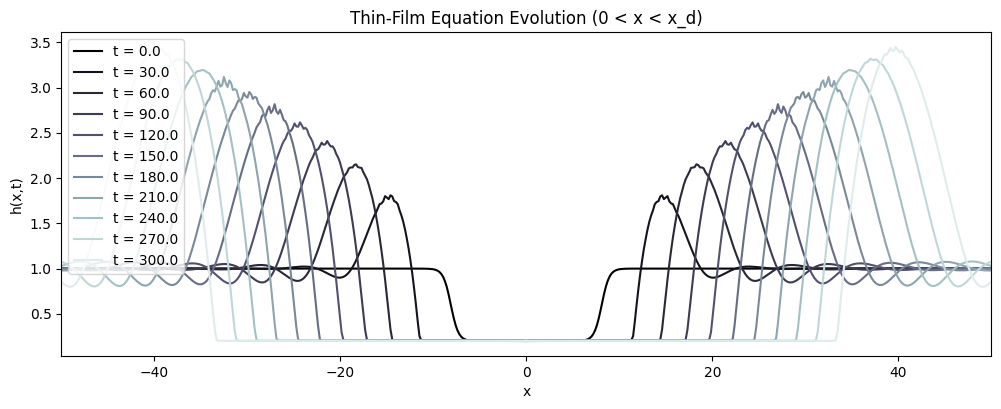

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Option to control aspect ratio (set to None to use default)
aspect_ratio = x_d/10  # e.g., 1 for unity, 2 for twice as tall, etc.

# Choose an interesting colormap
cmap = plt.get_cmap('bone')

# Determine the indices to plot (every 10th time slice for clarity)
plot_indices = np.arange(0, len(sol.t), 10)
colors = [cmap(i/len(plot_indices)) for i in range(len(plot_indices))]

plt.figure(figsize=(12, 6))
for idx, color in zip(plot_indices, colors):
    t_val = sol.t[idx]
    # Plot for positive x
    plt.plot(x, sol.y[:, idx], label=f"t = {t_val:.1f}", color=color)
    # Plot for negative x (mirror reflection)
    plt.plot(-x, sol.y[:, idx], color=color)

plt.xlabel("x")
plt.ylabel("h(x,t)")
plt.title("Thin-Film Equation Evolution (0 < x < x_d)")
plt.legend(loc="upper left")
# plt.grid(True)
plt.xlim(-50,50)


# Optionally set the aspect ratio
if aspect_ratio is not None:
    plt.gca().set_aspect(aspect_ratio, adjustable='box')

plt.show()


Create a waterfall-like plot of the evolution:

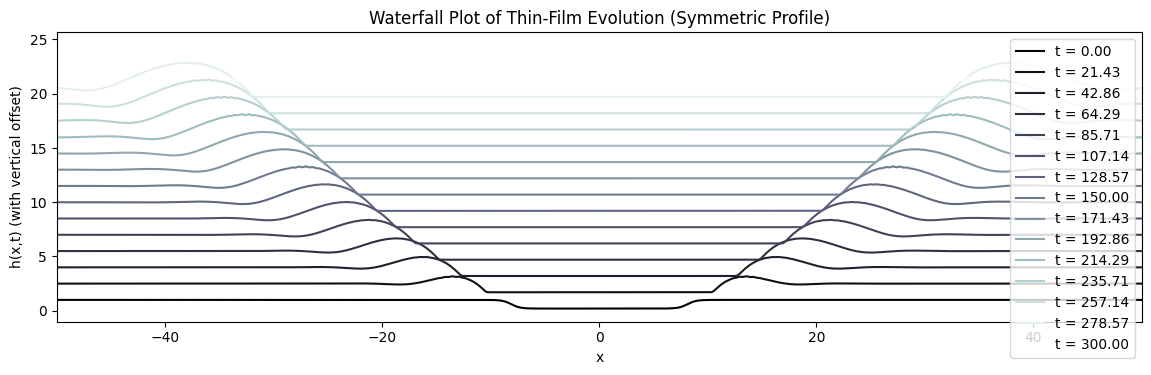

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------
# Waterfall Plot of Thin-Film Evolution
# --------------------------

# Selected time instants (you can adjust these as needed)
times_to_plot = np.linspace(0, tf, 15)
cmap = plt.get_cmap('bone')
colors = [cmap(i) for i in np.linspace(0, 1, len(times_to_plot))]

# Vertical offset between successive curves (for waterfall effect)
offset = 1.5

plt.figure(figsize=(14, 10))
for idx, t_val in enumerate(times_to_plot):
    # Find the index in the time array corresponding to t_val
    idx_sol = np.argmin(np.abs(sol.t - t_val))
    # Get the profile (for x in [0, x_d])
    h_slice = sol.y[:, idx_sol]
    
    # Construct the full domain by mirroring:
    # Exclude the first point from the mirrored copy (to avoid duplicating x=0)
    x_full = np.concatenate((-x[1:][::-1], x))
    h_full = np.concatenate((h_slice[1:][::-1], h_slice))
    
    # Apply a vertical offset (the offset can represent "time" in the waterfall plot)
    h_offset = h_full + idx * offset
    
    plt.plot(x_full, h_offset, '-', color=colors[idx], label=f't = {t_val:.2f}')

# Set aspect ratio to unity
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('x')
plt.ylabel('h(x,t) (with vertical offset)')
plt.title('Waterfall Plot of Thin-Film Evolution (Symmetric Profile)')
plt.legend(loc='upper right')
plt.xlim(-50,50)
# plt.grid(True)
plt.show()
